<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP ( Part 2 )

## About the project

This project covers three of the biggest concepts we cover in the class: **Classification Modeling, Natural Language Processing and Data Wrangling/Acquisition**.

For this project, we will be scraping data from two subreddits. Thereafter, we will apply Natural Language Processing to train a classifier to classify which subreddit a particular post comes from.

---

## Problem Statement

According to Bachmann S. Epidemiology of Suicide and the Psychiatric Perspective, most suicides are related to psychiatric disease, with depression, substance use disorders and psychosis being the most relevant risk factors. In view of this statistic, a newly developed social media application, Chipper, has implemented a new feature where users are able to report other users' posts for suspected mental health issue so that they will be able to provide help to these users before it is too late.

As a data scientist working in this company, I am tasked to train a classifier that will categorise posts that were
reported for mental health issues into either Anxiety or Depression so that we are able to route these users to its appropriate helpline. The **two classifiers we will be using in this project are Logistic Regression and Naive Bayes**. To train the classifier, I will be using posts from **Reddit's r/Anxiety and r/Depression subreddits as proxy data**.

Source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6165520/#B1-ijerph-15-02028

## Success Metrics

For this project to be considered successful, we will aim to optimise **Accuracy and Precision Score**.

`Accuracy ` refers to the ratio of the number of correct predictions and the total number of predictions. We want high accuracy as it would mean that the model has the ability to classify posts correctly to their respective categories.

`Precision score` explains how many of the correctly predicted cases actually turned out to be positive. E.g. In our case, it would mean the number of instances we predict `Depression` and it is actually `Depression`. We want to be able to correctly route as many users to their appropriate helpline and wrong classifications could mean that users were not able to receive the help they need.

With this in mind, we will be trying to hit the **target of greater than 90% for Accuracy and Precision Score**.

---

## Table of Contents
 - [Import Libraries](#Import-Libraries)

 - [Data Cleaning](#Data-Cleaning)

 - [Data Pre-processing](#Data-Pre-processing)
 
 - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
 
 - [Model Pre-processing](#Model-Pre-processing)
 
 - [Modeling](#Modeling)
 
  - [Bag of Words](#Bag-of-Words)
  - [TF-IDF(Uni-Gram)](#TF-IDF-(Uni-Gram))
  - [TF-IDF(Bi-Gram)](#TF-IDF-(Bi-Gram))

 - [Final Model Selection](#Final-Model-Selection)
 - [Conclusion & Recomendations](#Conclusion-&-Recomendations)

---

## Import Libraries

In [99]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, CategoricalNB
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

---

## Data Cleaning

As the first step to our process, we will have to start by cleaning the datasets.

---

###### Import Data

In [100]:
anxiety = pd.read_csv('./datasets/anxiety.csv')
depression = pd.read_csv('./datasets/depression.csv')

###### Dropping unnecessary columns

In [101]:
anxiety.drop(columns='Unnamed: 0', axis=1, inplace=True)
depression.drop(columns='Unnamed: 0', axis=1, inplace=True)

###### Drop null values

In [102]:
depression.dropna(inplace=True)
anxiety.dropna(inplace=True)

###### Removing `[removed]` and `[deleted]` posts

In [103]:
depression = depression[depression['selftext'] != '[removed]']
anxiety = anxiety[anxiety['selftext'] != '[removed]']

depression = depression[depression['selftext'] != '[deleted]']
anxiety = anxiety[anxiety['selftext'] != '[deleted]']

###### Combining title and selftext

Combining both title and text as there are useful information in the titles itself.

In [104]:
depression['title_selftext'] = depression['title'] + " " + depression['selftext']
anxiety['title_selftext'] = anxiety['title'] + " " + anxiety['selftext']

###### Categorising

In order for classification, we have to label the categories as 1 or 0. In this case, **1 represents Depression** while **0 represents Anxiety**.

In [105]:
depression['subreddit'] = 1
anxiety['subreddit'] = 0

###### Creating combined dataframe

Combining both Depression and Anxiety dataframes so that we will be able to perform train-test split later on to train our classification models.

In [106]:
df = pd.merge(depression,anxiety, how='outer')

In [107]:
# further removing unnecessary columns
df = df[['subreddit','title_selftext']]

In [108]:
# we have 5335 rows of texts
df.shape

(5335, 2)

---

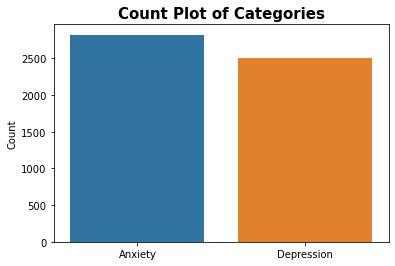

In [109]:
# plot countplot
sns.countplot(x=df["subreddit"])

# plot title
plt.title('Count Plot of Categories', fontsize=15, fontweight='bold')

# x and y labels
plt.xlabel('')
plt.ylabel('Count')

# replace 0 and 1 with Anxiety and Depression
plt.xticks([0,1],['Anxiety','Depression'])

plt.show()

Based on the count plot above, we can see that there is almost an equal amount of posts from each category. This is important as having an unequal number of posts from each category may affect our model's accuracy.

---

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|subreddit|int| (1) : r/Depression / (0) : r/Anxiety|
|title_selftext|string|post of the reddit user|

---

## Data Pre-processing

In order to perform NLP, we will have to process our data into a state where it is ready to be used for modeling.

---

In [110]:
# list of stopwords
stopword = nltk.corpus.stopwords.words('english')

# lemmatizer
wn = nltk.WordNetLemmatizer()

We will be choosing lemmatizing over stemming. Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling while lemmatization considers the context and converts the word to its meaningful base form.

###### Pre-processing functions

In [111]:
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

def tokenize(text):
    # Matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens


def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword]
    return text

def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

def remove_useless(column):
    # remove words longer than 20 letters (e.g websites)
    text = [word for word in column if len(word) < 20]
    return text

def remove_number(text):
    # remove words that start or ends with a number
    text = [re.sub(r"^\d+|\d$","",word) for word in text]
    return text

def join_list(text):
    # joins back list for count_vectorizer
    text = " ".join([char for char in text])
    return text

    

###### Apply pre-processing functions

In [112]:
# using .apply(), we will apply all of the functions defined above
df['text_clean'] = df['title_selftext'].apply(lambda x: remove_punct(x))
df['text_clean'] = df['text_clean'].apply(lambda x: tokenize(x.lower()))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatizing(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_useless(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_number(x))
df['text_clean'] = df['text_clean'].apply(lambda x: join_list(x))

In [113]:
# since we only require the category and the text
df = df[['subreddit','text_clean']]

---

## Exploratory Data Analysis

---

### "Most Common Words" Function

In [114]:
def top_15_words(label,num):
    # instantiating countvectorizer
    cv = CountVectorizer(stop_words='english',ngram_range=(num, num))
    # fit countvectorizer
    cv.fit(df['text_clean'].loc[df['subreddit']==label])

    # get dataframe of word and its count
    status_cv = cv.transform(df['text_clean'].loc[df['subreddit']==label])
    status_df = pd.DataFrame(status_cv.todense(), columns=cv.get_feature_names())

    plt.figure(figsize=(7,7))
    status_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')


### Distribution of Post Lengths

###### `Anxiety`

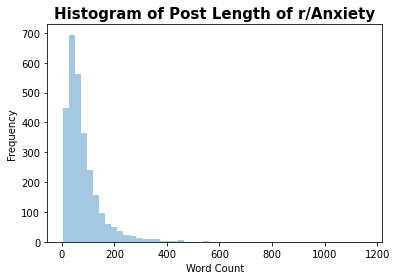

In [115]:
# plot histogram
sns.distplot(df['text_clean'].loc[df['subreddit']==0].map(lambda x: len(x.split())),kde=False)

# x and y labels
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# plot title
plt.title('Histogram of Post Length of r/Anxiety', fontsize=15, fontweight='bold');

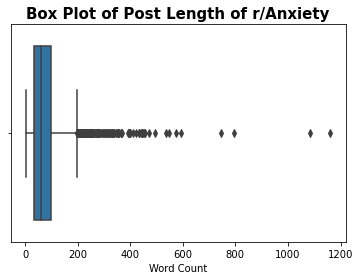

In [116]:
# boxplot 
sns.boxplot(df['text_clean'].loc[df['subreddit']==0].map(lambda x: len(x.split())))

# changing x label
plt.xlabel('Word Count')

# plot title
plt.title('Box Plot of Post Length of r/Anxiety', fontsize=15, fontweight='bold');

###### `Depression`

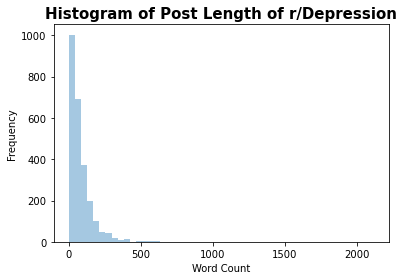

In [117]:
# plot histogram
sns.distplot(df['text_clean'].loc[df['subreddit']==1].map(lambda x: len(x.split())),kde=False)

# changing x and y labels
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# plot title
plt.title('Histogram of Post Length of r/Depression', fontsize=15, fontweight='bold');

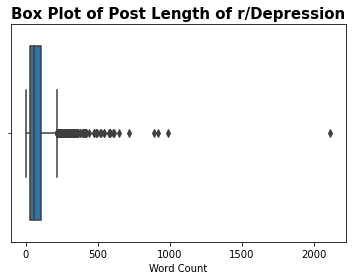

In [118]:
# boxplot
sns.boxplot(df['text_clean'].loc[df['subreddit']==1].map(lambda x: len(x.split())))

# changing x label
plt.xlabel('Word Count')

# plot title
plt.title('Box Plot of Post Length of r/Depression', fontsize=15, fontweight='bold');

Based on the distributions above, we can see that generally posts of from both subreddit are right-skewed. Generally, the posts seem to have about 400 words. However, the difference between the post lengths comes from the outliers, the maximum words for r/Depression posts reaches up to 2115 words while the maximum words for r/Anxiety reaches up to 1161. 

### Top 15 Words

###### `Depression`

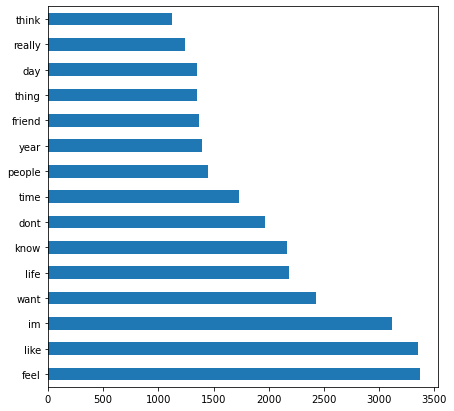

In [119]:
# using predefined function to get top 15 words in r/depression
top_15_words(1,1)

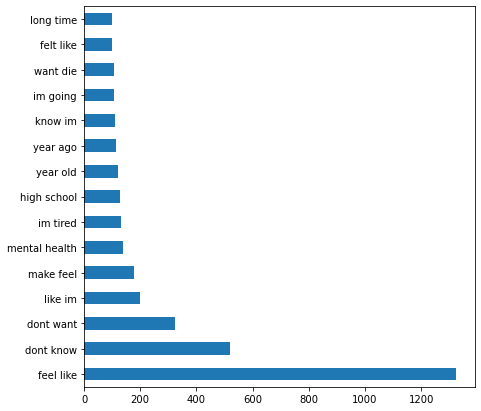

In [120]:
# using predefined function to get top 15 two-worded words in r/depression
top_15_words(1,2)

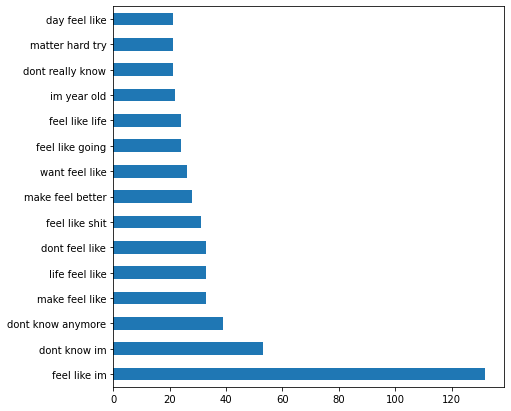

In [121]:
# using predefined function to get top 15 three-worded words in r/depression
top_15_words(1,3)

###### `Anxiety`

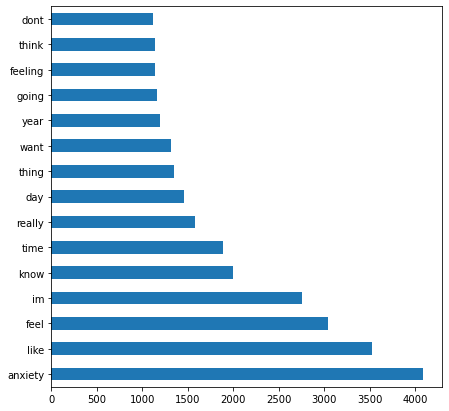

In [122]:
# using predefined function to get top 15 words in r/anxiety
top_15_words(0,1)

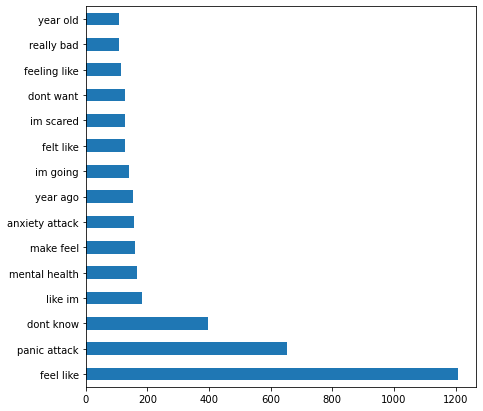

In [123]:
# using predefined function to get top 15 two-worded words in r/anxiety
top_15_words(0,2)

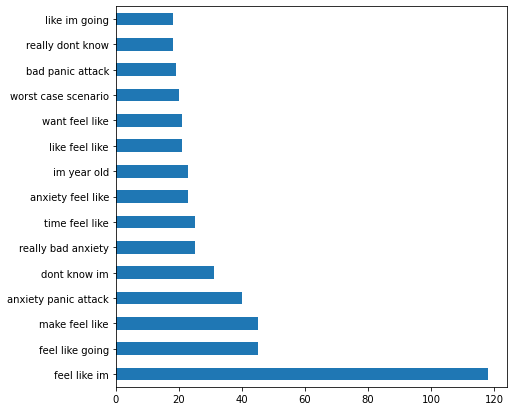

In [124]:
# using predefined function to get top 15 three-worded words in r/anxiety
top_15_words(0,3)

Judging from the top 15 most frequently appearing words of Uni-Gram, Bi-Gram and Tri-Grams, there are quite a number of meaningless terms. Top words for all Bi-Gram and Tri-Gram seems to contain 'Feel like'. **Moving forward, we hope that after applying various vectorization methods and modeling, our classifiers would be able to pick up words that have more meaning as its features**.

---

## Model Pre-processing

Before modeling, we will have to perform a train-test split.

---

###### Train-Test Split

In [125]:
# features (in this case, the words)
X = df["text_clean"].tolist()

# target variable (0 or 1)
y = df["subreddit"].tolist()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

## Modeling

For our models, we will be investingating whether Logistic Regression or Naive Bayes would yield us better results.

**Logistic regression** works by measuring the relationship between the dependent variable (what we want to predict) and one or more independent variables (the features). It does this by estimating the probabilities with the help of its underlying logistic function.

**Naive Bayes** is a probabilistic classifier, which means it predicts on the basis of the probability of an object.

With these models, we will predict whether a post from reddit is classified as `Anxiety (0)` or `Depression (1)` 

---

### Vectorizer Functions

In [126]:
# countvectorizer
def cv(data):
    # instantiating countvectorizer
    count_vectorizer = CountVectorizer()
    # word embedding
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# tfidf
def tfidf(data,num):
    # instantiating tfidfvectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(num,num))
    
    # word vector
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

---

### Modeling Functions

Below function instantiates model, fits model, make predictions and prints metrics for evaluation.

###### Logistic Regression

In [127]:
def log_reg(X_train, X_test):
    LogReg = LogisticRegression()
    # instantiating model (with hyperparameters personally tuned)
    LogReg = LogisticRegression(C=0.75, class_weight='balanced', solver='newton-cg')
            
    # model fitting
    LogReg.fit(X_train, y_train)

    # making prediction
    y_pred_train = LogReg.predict(X_train)
    y_pred_test = LogReg.predict(X_test)

    # saving the train and test scores
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)

    # printing train and test scores 
    print('============================================================')
    print(f" Train Score: {round(train_score,4)}")
    print(f" Test Score: {round(test_score,4)}")
    print('============================================================')
    print(classification_report(y_test, y_pred_test))
    print('============================================================')

    return LogReg

###### Naive-Bayes 

In [128]:
def naive_bayes_bernoulli(X_train, X_test):
    # instantiating model
    BernNB = BernoulliNB()
    # model fitting
    BernNB.fit(X_train, y_train)

    # making prediction
    y_pred_train = BernNB.predict(X_train)
    y_pred_test = BernNB.predict(X_test)

    # saving the train and test scores
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)

    # printing train and test scores 
    print('============================================================')
    print(f" Train Score: {round(train_score,4)}")
    print(f" Test Score: {round(test_score,4)}")
    print('============================================================')
    # print classification report
    print(classification_report(y_test, y_pred_test))
    print('============================================================')
    
    return BernNB

In [129]:
def naive_bayes_multinomial(X_train, X_test):
    # instantiating model
    MultNB = MultinomialNB()
    # model fitting
    MultNB.fit(X_train, y_train)

    # making prediction
    y_pred_train = MultNB.predict(X_train)
    y_pred_test = MultNB.predict(X_test)
    
    # saving the train and test scores
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)

    # printing train and test scores
    print('============================================================')
    print(f" Train Score: {round(train_score,4)}")
    print(f" Test Score: {round(test_score,4)}")
    print('============================================================')
    print(classification_report(y_test, y_pred_test))
    print('============================================================')
    
    return MultNB

---

### Visualisation Functions

###### For Bar Graph of Most Important Features

Below function plots bar graph of words with the highest regression coefficients.

In [130]:
def plot_importance(vectorizer,model):

    # Create df for storing coefficients and their corresponding variable names
    coefficient_df = pd.DataFrame()
    # Storing all the column names of predictors
    coefficient_df['Column_Name'] = list(vectorizer.get_feature_names_out())
    # Store coefficients of predictors
    coefficient_df['Coefficient_Value'] = pd.Series(model.coef_.flatten())
    # Preview variables' coefficient values
    # The higher the values, the stronger the variables
    coefficient_df_sort = coefficient_df.copy()
    coefficient_df_sort.sort_values(by='Coefficient_Value', ascending = True, inplace = True)
    
    # store greatest coefficients of words from r/anxiety
    anxietycoef = coefficient_df_sort.head(10)
    # store greatest coefficients of words from r/depression
    depressioncoef = coefficient_df_sort.tail(10)
    
    # so that the barchart goes from greatest to smallest
    depressioncoef.sort_values(by='Coefficient_Value',ascending=True,inplace=True)
    anxietycoef.sort_values(by='Coefficient_Value',ascending=False,inplace=True)
    
    # figure size
    fig = plt.figure(figsize=(13, 10))
    
    # plot bargraph of most relevant words in r/depression
    plt.subplot(122)
    ax = plt.barh(depressioncoef.iloc[:,0],depressioncoef.iloc[:,1], align='center', alpha=0.5,color='red')
    plt.title('Depression', fontsize=20)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    # plot bargraph of most relevant words in r/anxiety
    plt.subplot(121)
    plt.barh(anxietycoef.iloc[:,0],anxietycoef.iloc[:,1], align='center', alpha=0.5, color='blue')
    plt.title('Anxiety', fontsize=20)
    plt.suptitle("Most important words for relevance", fontsize=15, fontweight='bold')
    plt.xlabel('Importance', fontsize=20)

###### Visualise Separability

Below function plots a 2D graph by reducing dimensionality of the entire dataset.

In [131]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        # dimensionality reduction using truncated SVD
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Anxiety')
            green_patch = mpatches.Patch(color='blue', label='Depression')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 15})
            plt.title('Separation between Categories', fontsize=15, fontweight='bold')

---

### Bag of Words

Bag of Words uses Count Vectorizer which creates a document-term matrix where the entry of each cell will be a count of the number of times that word occurred in that document.

In [132]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

###### Separability

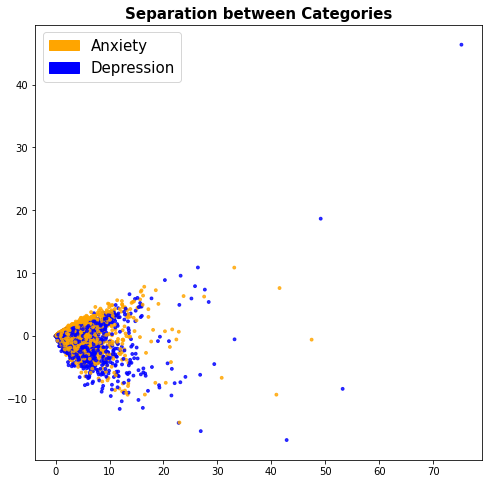

In [133]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

Based on the visualisation above, we see that the data points of the two categories does not have a distinct separation when using Bag of Words. **The clearer the separation, the easier it is for the classification models to learn from**.

### Model Scores

###### Naive Bayes Bernoulli

In [134]:
BernNB = naive_bayes_bernoulli(X_train_counts, X_test_counts)

 Train Score: 0.9208
 Test Score: 0.85
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       556
           1       0.86      0.82      0.84       511

    accuracy                           0.85      1067
   macro avg       0.85      0.85      0.85      1067
weighted avg       0.85      0.85      0.85      1067



###### Naive Bayes Multinomial

In [135]:
MultNB = naive_bayes_multinomial(X_train_counts, X_test_counts)

 Train Score: 0.9278
 Test Score: 0.8744
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       556
           1       0.86      0.88      0.87       511

    accuracy                           0.87      1067
   macro avg       0.87      0.87      0.87      1067
weighted avg       0.87      0.87      0.87      1067



###### Logistic Regression

In [136]:
LogReg = log_reg(X_train_counts, X_test_counts)

 Train Score: 0.9934
 Test Score: 0.8932
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       556
           1       0.88      0.90      0.89       511

    accuracy                           0.89      1067
   macro avg       0.89      0.89      0.89      1067
weighted avg       0.89      0.89      0.89      1067



###### AUC-ROC Curve

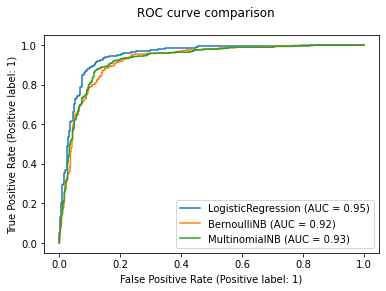

In [137]:
# plot roc curve
lr_disp = plot_roc_curve(LogReg, X_test_counts, y_test)
bern_disp = plot_roc_curve(BernNB, X_test_counts, y_test, ax=lr_disp.ax_)
mult_disp = plot_roc_curve(MultNB, X_test_counts, y_test, ax=lr_disp.ax_)

mult_disp.figure_.suptitle("ROC curve comparison")

plt.show()

To understand the plot above, we need to understand that the AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Therefore, the higher tha AUC, the better the model is at distinguishing between users with `Anxiety` or `Depression`.

Based on the plot above, we can see that the Logistic Regression model has the highest AUC.

---

### Summary of Scores

|Model|Method|Accuracy (Train)|Accuracy (Test)|Precision (0)|Precision (1)|AUC|
|---|---|---|---|---|---|---|
|**Logistic Regression**|**Bag of Words**|**0.9934**|**0.8932**|**0.91**|**0.88**|**0.94**|
|Naive Bayes Bernouli|Bag of Words|0.9208|0.8500|0.84|0.86|0.92|
|Naive Bayes Multinomial|Bag of Words|0.9278|0.8744|0.89|0.86|0.93|


From the summary of scores, we can see that the difference between the train and test accuracy score of Logistic Regression is greater than 0.1. This means that there is overfitting to the train data and is underperforming on unseen data. Other than this flaw, the Logistic Regression model offers the higher accuracy and precision score in comparison to the other two models. 

Therefore, we conclude that **Logistic Regression is the best model in this section**. In the following part, we will evaluate this model with visualisations.

---

### Logistic Regression ( Bag of Words )

###### Confusion Matrix

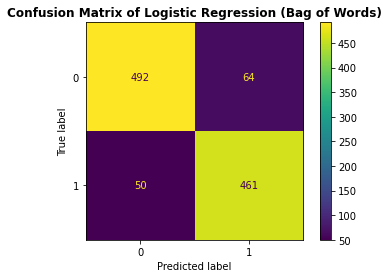

In [138]:
# plot confusion matrix
predictions = LogReg.predict(X_test_counts)
cm = confusion_matrix(y_test, predictions, labels=LogReg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogReg.classes_)

disp.plot()
plt.title('Confusion Matrix of Logistic Regression (Bag of Words)',fontsize=12,fontweight='bold')

plt.show()

The confusion matrix above visualises the True Positive, True Negative, False Positive and False Negative values. These are the values that were used to calculate the Accuracy and Precision score.

###### Most Relevant Words

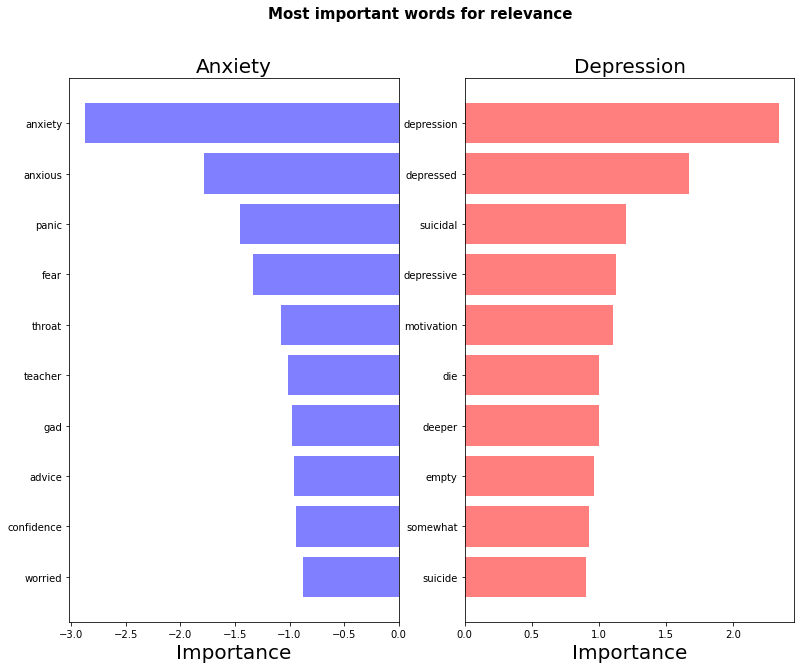

In [139]:
plot_importance(count_vectorizer,LogReg)

Based on the bar chart above, we can see that there are **a few meaningless words**. This means that this model is overfitting on a few meaningless terms. 

For `Anxiety`, these words are "reminder, teacher and confidence." The word "confidence" can be misleading and it is hard to think of how the word "reminder" and "teacher" made it on the list. Even though the word "gad" looks like a meaningless term, it actually stands for Generalized Anxiety Disorder. 

For `Depression`, there is a meaningless word "somewhat". If I were to guess, the reason why the word "motivation" made it onto the list is probably due to the fact that people who experience depression typically feels that they have no motivation.

Comparing the words from both `Anxiety` and `Depression`, we can see that people with anxiety typically has panic attacks while people with depression tends to be suicidal.

This amplifies the importance of this project as someone's life may be on the line. If we were able to correctly route as many users who experience depression to appropriate helplines, we may be able to save lives. Therefore, it is important that we have a high precision score due to this fact.

---

### TF-IDF (Uni-Gram)

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

In [140]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train,1)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

###### Separability

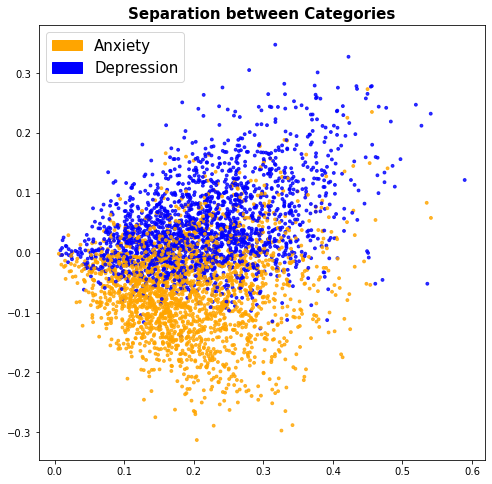

In [141]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Based on the visualisation above, we can see that after applying TF-IDF (Uni-Gram), it should not be surprising to us there is a **better separation** and the data points are more spread out between the two categories as compared to Bag of Words.

### Model Scores

###### Naive Bayes Bernoulli

In [142]:
BernNB_TFIDF_Unigram = naive_bayes_bernoulli(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9208
 Test Score: 0.85
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       556
           1       0.86      0.82      0.84       511

    accuracy                           0.85      1067
   macro avg       0.85      0.85      0.85      1067
weighted avg       0.85      0.85      0.85      1067



###### Naive Bayes Multinomial

In [143]:
MultNB_TFIDF_Unigram = naive_bayes_multinomial(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9253
 Test Score: 0.8735
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       556
           1       0.89      0.85      0.86       511

    accuracy                           0.87      1067
   macro avg       0.87      0.87      0.87      1067
weighted avg       0.87      0.87      0.87      1067



###### Logistic Regression

In [144]:
LogReg_TFIDF_Unigram = log_reg(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9363
 Test Score: 0.911
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       556
           1       0.90      0.92      0.91       511

    accuracy                           0.91      1067
   macro avg       0.91      0.91      0.91      1067
weighted avg       0.91      0.91      0.91      1067



###### AUC-ROC Curve

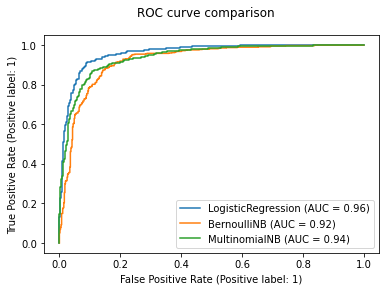

In [145]:
# plot roc-curve
lr_disp = plot_roc_curve(LogReg_TFIDF_Unigram, X_test_tfidf, y_test)
bern_disp = plot_roc_curve(BernNB_TFIDF_Unigram, X_test_tfidf, y_test, ax=lr_disp.ax_)
mult_disp = plot_roc_curve(MultNB_TFIDF_Unigram, X_test_tfidf, y_test, ax=lr_disp.ax_)

mult_disp.figure_.suptitle("ROC curve comparison")

plt.show()

Based on the plot above, we can see that Logistic Regression continues to have the best AUC score. And as compared to the previous model, it is a 0.2 improvement. 

---

### Summary of Scores

|Model|Method|Accuracy (Train)|Accuracy (Test)|Precision (0)|Precision (1)|AUC|
|---|---|---|---|---|---|---|
|**Logistic Regression**|**TF-IDF (Uni-Gram)**|**0.9363**|**0.9110**|**0.91**|**0.90**|**0.96**|
|Naive Bayes Bernouli|TF-IDF (Uni-Gram)|0.9208|0.8500|0.84|0.86|0.92|
|Naive Bayes Multinomial|TF-IDF (Uni-Gram)|0.9253|0.8735|0.87|0.89|0.94|


Based on the summary of scores, we can see that after applying the TF-IDF method, there is a significant reduction in the difference in train and test accuracy scores of Logistic Regression. With a train accuracy of 0.9363 and test accuracy of 0.9110, it is looking acceptable.

The Naive Bayes scores after applying the TF-IDF method compared to Bag of Words method, did not have much difference. 

After comparing all the models in this section, we can see that Logistic Regression still continues to be the better model.

Therefore, we conclude that **Logistic Regression is the best model in this section**. In the following part, we will evaluate this model with visualisations.

---

### Logistic Regression (TF-IDF Uni-Gram)

###### Confusion Matrix

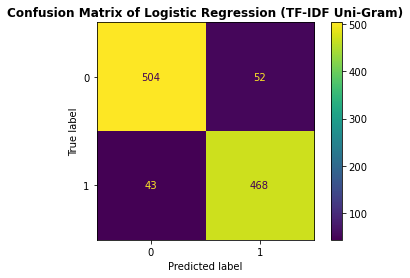

In [146]:
# plot confusion matrix
predictions = LogReg_TFIDF_Unigram.predict(X_test_tfidf)
cm = confusion_matrix(y_test, predictions, labels=LogReg_TFIDF_Unigram.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogReg_TFIDF_Unigram.classes_)

disp.plot()
plt.title('Confusion Matrix of Logistic Regression (TF-IDF Uni-Gram)',fontsize=12,fontweight='bold')

plt.show()

The confusion matrix above visualises the True Positive, True Negative, False Positive and False Negative values. These are the values that were used to calculate the Accuracy and Precision score. 

In comparison to the confusion matrix of Logistic Regression using Bag of Words, we can see that there is a slight **increase in correct predictions and reduction of wrong predictions**. Although the increase is slight, it is still significant as we want to be able to reduce as many misclassifications as possible.

###### Most Relevant Words

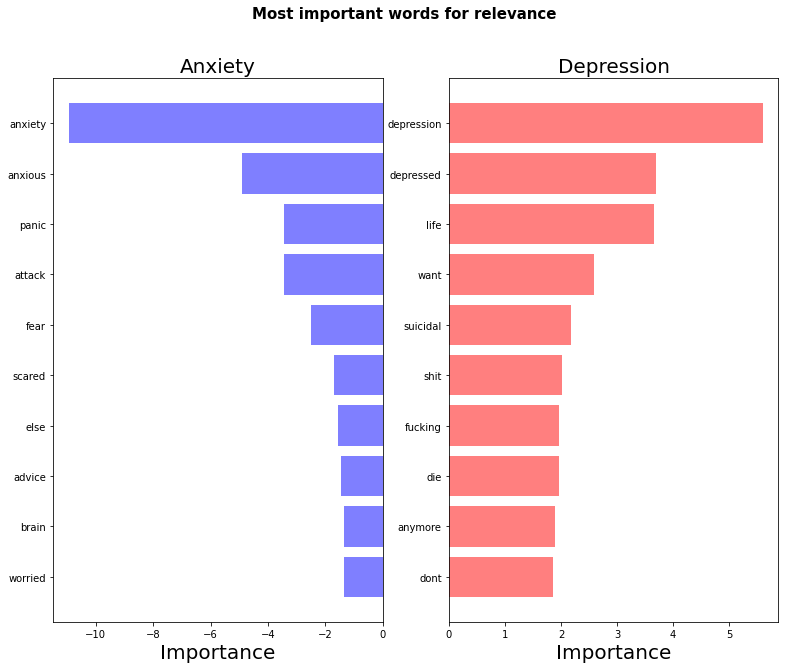

In [147]:
plot_importance(tfidf_vectorizer,LogReg_TFIDF_Unigram)

Based on the bar chart above, we can see that there are **fewer meaningless words after applying TF-IDF (Uni-Gram)**. Although there are still meaningless terms such as 'else', it is significantly lesser as compared to the model that uses Bag of Words. This is also expected as per what we saw from the separability chart, since the data points were more spread out, the model is then able to learn better, hence, reducing the overfitting on meaningless terms.

It is also not surprising that the words with the highest coefficients are "Anxiety" and "Depression" itself. This means that if "Depression" appears in a post, it is more likely to be classified as Depression than if "sad" appears in a post. E.g. If the content of the post is "I feel depressed and sad", it will most likely be classified as Depression. 

---

### TF-IDF (Bi-Gram)

Similar to TF-IDF (Uni-Gram), except now two words are used instead of one.

In [148]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train,2)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

###### Separability

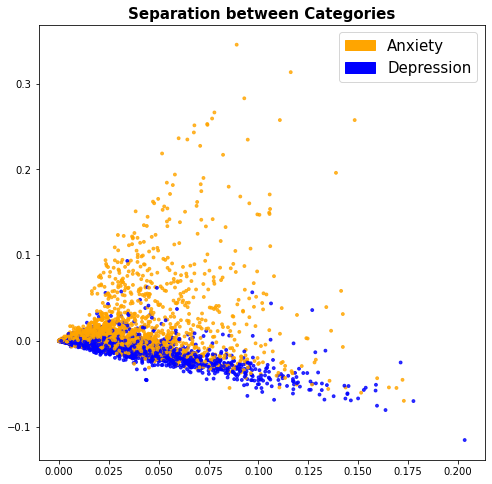

In [149]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

Even though it seems that there are some separation, but as compared to TF-IDF, there are still quite a lot of overlap between the two categories. The data points are also less spread out as compared to TF-IDF (Uni-Gram).

---

### Model Scores

---

###### Naive Bayes Bernoulli

In [150]:
BernNB_TFIDF_Bigram = naive_bayes_bernoulli(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9213
 Test Score: 0.6579
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       556
           1       0.91      0.32      0.47       511

    accuracy                           0.66      1067
   macro avg       0.76      0.64      0.61      1067
weighted avg       0.75      0.66      0.62      1067



###### Naive Bayes Multinomial

In [151]:
MultNB_TFIDF_Bigram = naive_bayes_multinomial(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9974
 Test Score: 0.8379
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       556
           1       0.87      0.77      0.82       511

    accuracy                           0.84      1067
   macro avg       0.84      0.84      0.84      1067
weighted avg       0.84      0.84      0.84      1067



###### Logistic Regression

In [152]:
LogReg_TFIDF_Bigram = log_reg(X_train_tfidf, X_test_tfidf)

 Train Score: 0.9934
 Test Score: 0.8247
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       556
           1       0.80      0.84      0.82       511

    accuracy                           0.82      1067
   macro avg       0.82      0.83      0.82      1067
weighted avg       0.83      0.82      0.82      1067



###### AUC-ROC Curve

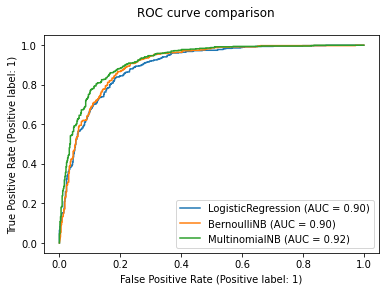

In [153]:
# plot roc-curve
lr_disp = plot_roc_curve(LogReg_TFIDF_Bigram, X_test_tfidf, y_test)
bern_disp = plot_roc_curve(BernNB_TFIDF_Bigram, X_test_tfidf, y_test, ax=lr_disp.ax_)
mult_disp = plot_roc_curve(MultNB_TFIDF_Bigram, X_test_tfidf, y_test, ax=lr_disp.ax_)

mult_disp.figure_.suptitle("ROC curve comparison")

plt.show()

By looking at the plot above, we can see that Naive Bayes Multinomial model did the best. But as compared to the model before this, it is a deprovement.  

---

### Summary of Scores

|Model|Method|Accuracy (Train)|Accuracy (Test)|Precision (0)|Precision (1)|AUC|
|---|---|---|---|---|---|---|
|Logistic Regression|TF-IDF (Bi-Gram)|0.9934|0.8247|0.84|0.82|0.91|
|Naive Bayes Bernouli|TF-IDF (Bi-Gram)|0.9213|0.6579|0.61|0.91|0.90|
|**Naive Bayes Multinomial**|**TF-IDF (Bi-Gram)**|**0.9974**|**0.8379**|**0.81**|**0.88**|**0.92**|


From the summary of scores, we see that after applying the TF-IDF (Bi-Gram) method, all of the models have a difference in train and test accuracy greater than 0.1. This means that all of the models suffer from overfitting to the train data. 

After comparing all three models, we can see that Naive Bayes Multinomial is the better performing model in this section. However, the fight between Logistic Regression and Naive Bayes multinomial is close. In the end, we chose Naive Bayes Multinomial as our best performing model in this section as it has the better scores in general.

Therefore, we conclude that **Naive Bayes Multinomial is the best model in this section**. In the following part, we will evaluate this model with visualisations.

---

### Naive Bayes Multinomial (TF-IDF Bi-Gram)

###### Confusion Matrix

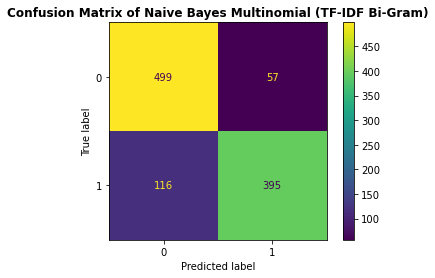

In [154]:
# plot confusion matrix
predictions = MultNB_TFIDF_Bigram.predict(X_test_tfidf)
cm = confusion_matrix(y_test, predictions, labels=MultNB_TFIDF_Bigram.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MultNB_TFIDF_Bigram.classes_)

disp.plot()
plt.title('Confusion Matrix of Naive Bayes Multinomial (TF-IDF Bi-Gram)',fontsize=12,fontweight='bold')

plt.show()

The confusion matrix above visualises the True Positive, True Negative, False Positive and False Negative values. These are the values that were used to calculate the Accuracy and Precision score.

In comparison to the confusion matrix of Logistic Regression using Bag of Words and Logistic Regression using TF-IDF (Uni-Gram), the confusion matrix of Naive Bayes Multinomial TF-IDF (Bi-Gram) did alot worse than the other two models. 

There is a greater than 50% increase in `Depression` posts being classified as `Anxiety`. This is a **costly mistake** as by wrongly classifying users, it means that they will not be able to receive help from the appropriate helplines. 

Therefore, it is unlikely we will use this model as our final model.

---

## Final Model Selection

                                                 Full Summary of Scores  

|Model|Method|Accuracy (Train)|Accuracy (Test)|Precision (0)|Precision (1)|AUC|
|---|---|---|---|---|---|---|
|Logistic Regression|Bag of Words|0.9934|0.8932|0.91|0.88|0.94|
|Naive Bayes Bernouli|Bag of Words|0.9208|0.8500|0.84|0.86|0.92|
|Naive Bayes Multinomial|Bag of Words|0.9278|0.8744|0.89|0.86|0.93|
|**Logistic Regression**|**TF-IDF (Uni-Gram)**|**0.9363**|**0.9110**|**0.91**|**0.90**|**0.96**|
|Naive Bayes Bernouli|TF-IDF (Uni-Gram)|0.9208|0.8500|0.84|0.86|0.92|
|Naive Bayes Multinomial|TF-IDF (Uni-Gram)|0.9253|0.8735|0.87|0.89|0.94|
|Logistic Regression|TF-IDF (Bi-Gram)|0.9934|0.8247|0.84|0.82|0.91|
|Naive Bayes Bernouli|TF-IDF (Bi-Gram)|0.9213|0.6579|0.61|0.91|0.90|
|Naive Bayes Multinomial|TF-IDF (Bi-Gram)|0.9974|0.8379|0.81|0.88|0.92|




Based on the summary of scores above, we will select the Final Model which is **Logistic Regression using TF-IDF (Uni-Gram)**.

It has an train accuracy of 0.9363, test accuracy of 0.9110, Precision(0) of 0.91 and Precision(1) of 0.90. It is the best model as compared to all the other models and it also meets our expectations of accuracy and precision score of greater than 0.90. As a bonus, it also has an AUC of 0.96 which is also the highest out of all the other models. 

---

## Conclusion & Recomendations

**Conclusion**

In conclusion, we have **successfully built a classifer that meets expectations of Accuracy and Precision score greater than 90%**. Other than building a successful model, some insights that I have discovered from evaluating the models is that posts in r/Depression talks more about wanting to die and feelings of hopelessness while posts in r/Anxiety talks more about panic attacks and feelings of anxiousness. This shows we should never overlook the effects of mental health issues especially depression where suicidal thoughts are involved.

Thankfully, the Chipper app now allows users to report posts that suggest that a particular user is suspected to be suffering from mental health issues. After the implementation of the final classifier model, we will be able to classify whether a user is suffering from anxiety or depression with a >90% accuracy and precision. This means that there will be an increase in accessibilty for these users to receive the help they need. 

**Limitations**:
1) In reality, users could suffer from both Depression and Anxiety. However, in this project, we assume that the subreddit that the users posts on is the predominant mental health issue they suffer from. For example, we assume that a user who posted on r/Depression to suffer predominantly from Depression.

2) Due to Chipper being a newly developed Social Media application, we do not have enough internal data, therefore, we are choosing to use reddit posts as our proxy data. As the application matures, we should switch to use internal data that accurately represents the type of posts users on Chippy posts.

**Reccomendations**:

1) As there are many more mental health issues than just Anxiety or Depression, we can expand the number of mental health issues our classifier can classify. 

2) In the future, Chipper can implement a feature that will automatically flag a post for suspected mental health issue without the need to wait for users to report such posts.

3) Chipper can work with these mental health issue helplines to come up with in-app campaigns that promote the importance of caring for these mental health issues. These campaigns could also raise awareness for mental health issues and educate users on how to identify and care for someone suffering from these mental health issues.